In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fm2p

Loading DLC 2.3.7...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


c:\Users\dmartins\anaconda3\envs\fm1\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [2]:
basepath = r'K:\Mini2P\241231_DMM_DMM038_freemoving'
rec_name = '241231_DMM_DMM038_freemoving_01'
session_props = r'K:\Mini2P\241231_DMM_DMM038_freemoving\session_props.json'

top = fm2p.Topcam(basepath, rec_name, props=session_props, rnum=1)
body_xyl, body_tracking_results = top.track_body()
# topvid = fm2p.pack_video_frames(top.top_avi)
# top.save_tracking(body_tracking_results, body_xyl, topvid)

twop = fm2p.TwoP(basepath, rec_name, props=session_props, rnum=1)
twop_dict = twop.calc_dFF()
# twop.save_fluor(twop_dict)

topdlc, _ = fm2p.open_dlc_h5(r'K:\Mini2P\241231_DMM_DMM038_freemoving\241231_DMM_DMM038_freemoving_01\241231_DMM_DMM038_freemoving_01_topdownTracking.h5')

86.77619656649503


In [ ]:
# np.sum(~np.isnan(body_tracking_results['head_yaw'])) / 6000

In [3]:
sps = twop_dict['spikes_per_sec']
pxls2cm = 86.33960307728161

iscell = twop.suite2p_outputs['iscell']
sps = twop_dict['s2p_spks'][iscell[:,0]==1, :]

cmap = plt.cm.hsv(np.linspace(0,1,360))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=300)
angles = np.arange(360)
radius = 0.25
for a in angles:
    x_points = radius * np.cos(np.deg2rad(a))
    y_points = radius * np.sin(np.deg2rad(a))
    ax.plot(x_points, y_points, marker='o', linestyle='-', markersize=12,
             color = cmap[a])
ax.axis('equal')
ax.invert_yaxis()
ax.axis('off')

In [ ]:
plt.plot(body_tracking_results['x'] / pxls2cm, body_tracking_results['y'] / pxls2cm, color='k')

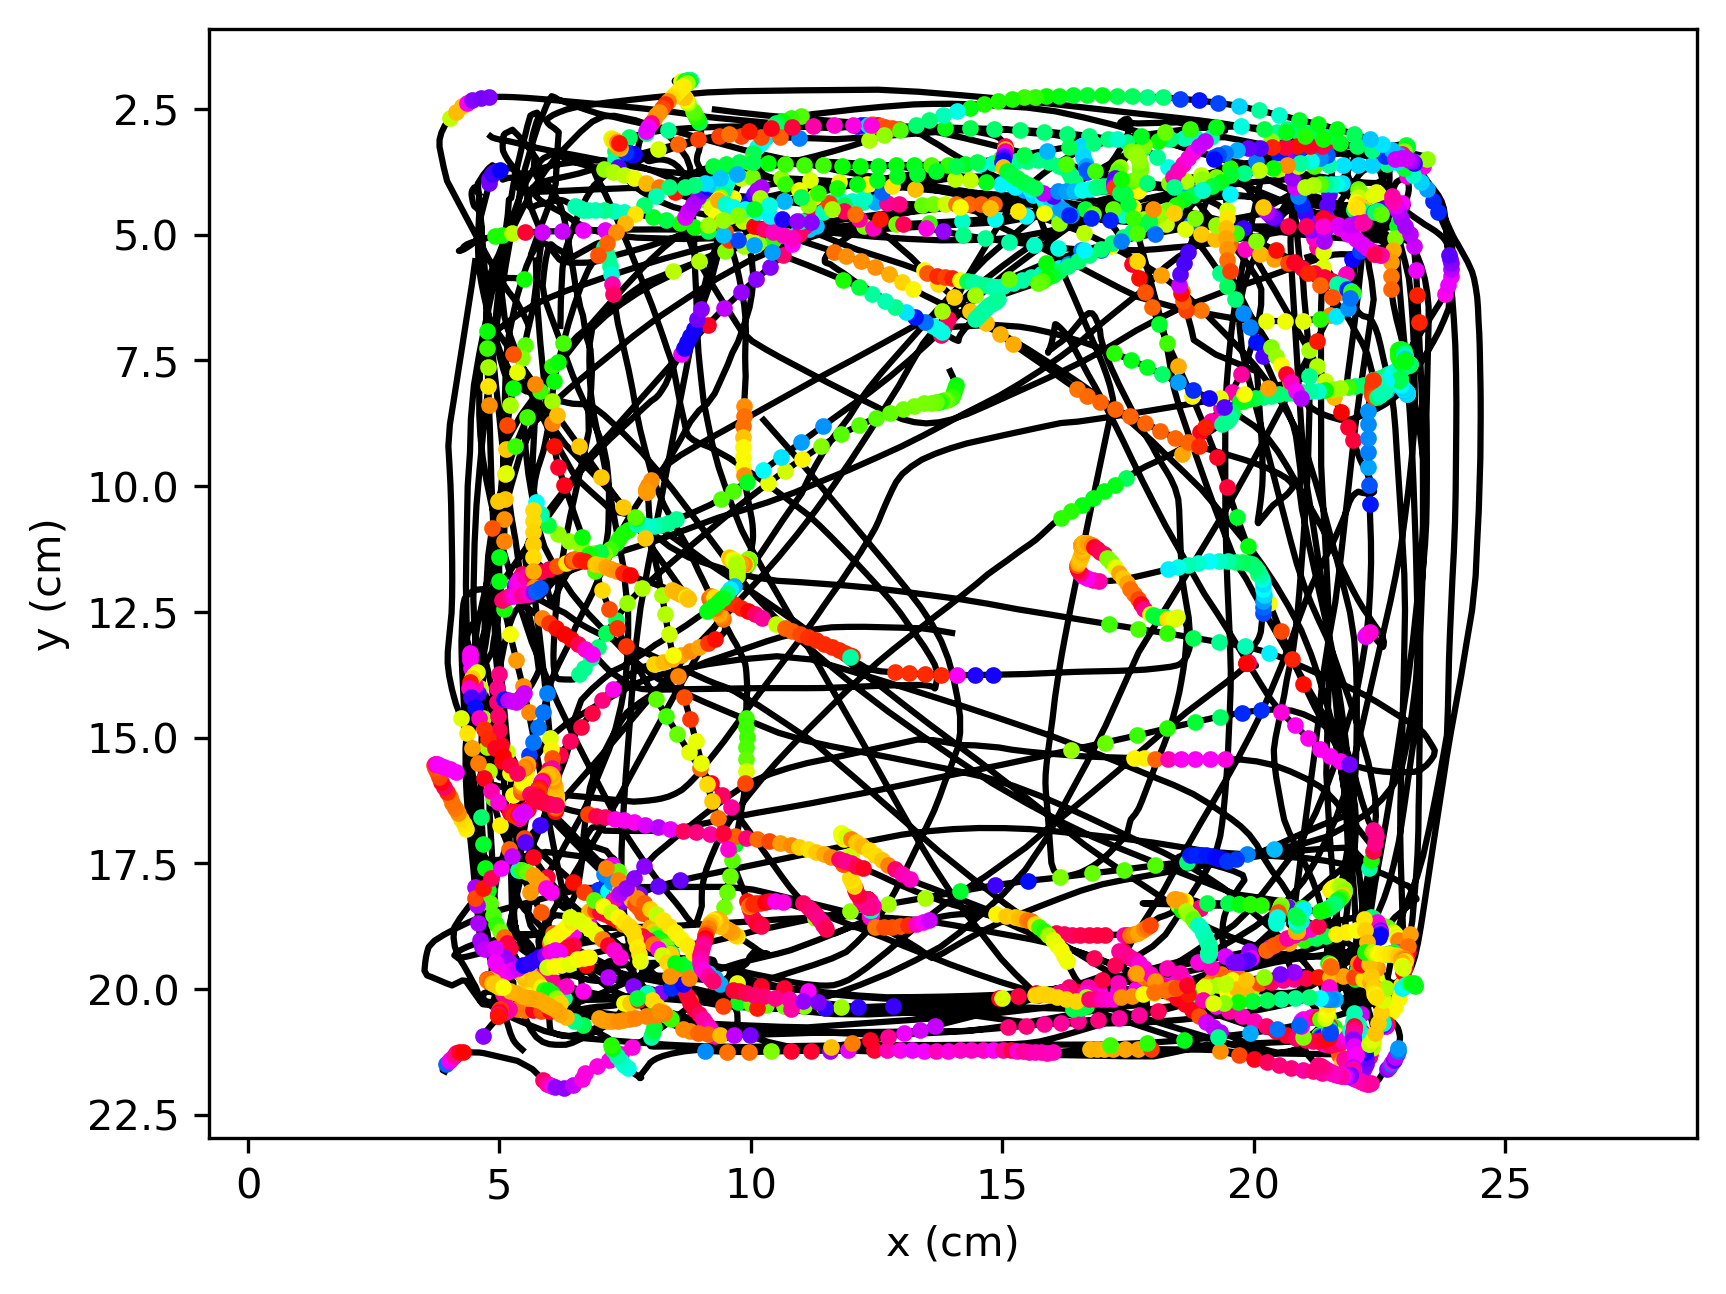

In [4]:
fig, ax = plt.subplots(1,1, dpi=300)
ax.axis('equal')
ax.plot(body_tracking_results['x'] / pxls2cm, body_tracking_results['y'] / pxls2cm, color='k')
for i in range(len(body_tracking_results['head_yaw_deg'])):
    if ~np.isnan(body_tracking_results['head_yaw_deg'][i]):
        ax.plot(body_tracking_results['x'][i] / pxls2cm, body_tracking_results['y'][i] / pxls2cm,
            'o', ms=3, color=cmap[int(body_tracking_results['head_yaw_deg'][i])])
# ax.invert_yaxis()
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
# ax.set_title('all frames')
ax.invert_yaxis()

In [ ]:
fig, ax = plt.subplots(1,1, dpi=300)
i = 2905
if (~np.isnan(body_tracking_results['head_yaw_deg'][i])):
    ax.imshow(topvid[i,:,:], cmap='gray')
    ax.plot(body_tracking_results['x'][i], body_tracking_results['y'][i],
        'o', ms=3, color=cmap[int(body_tracking_results['head_yaw_deg'][i])])

IndexError: index 14000 is out of bounds for axis 1 with size 13994

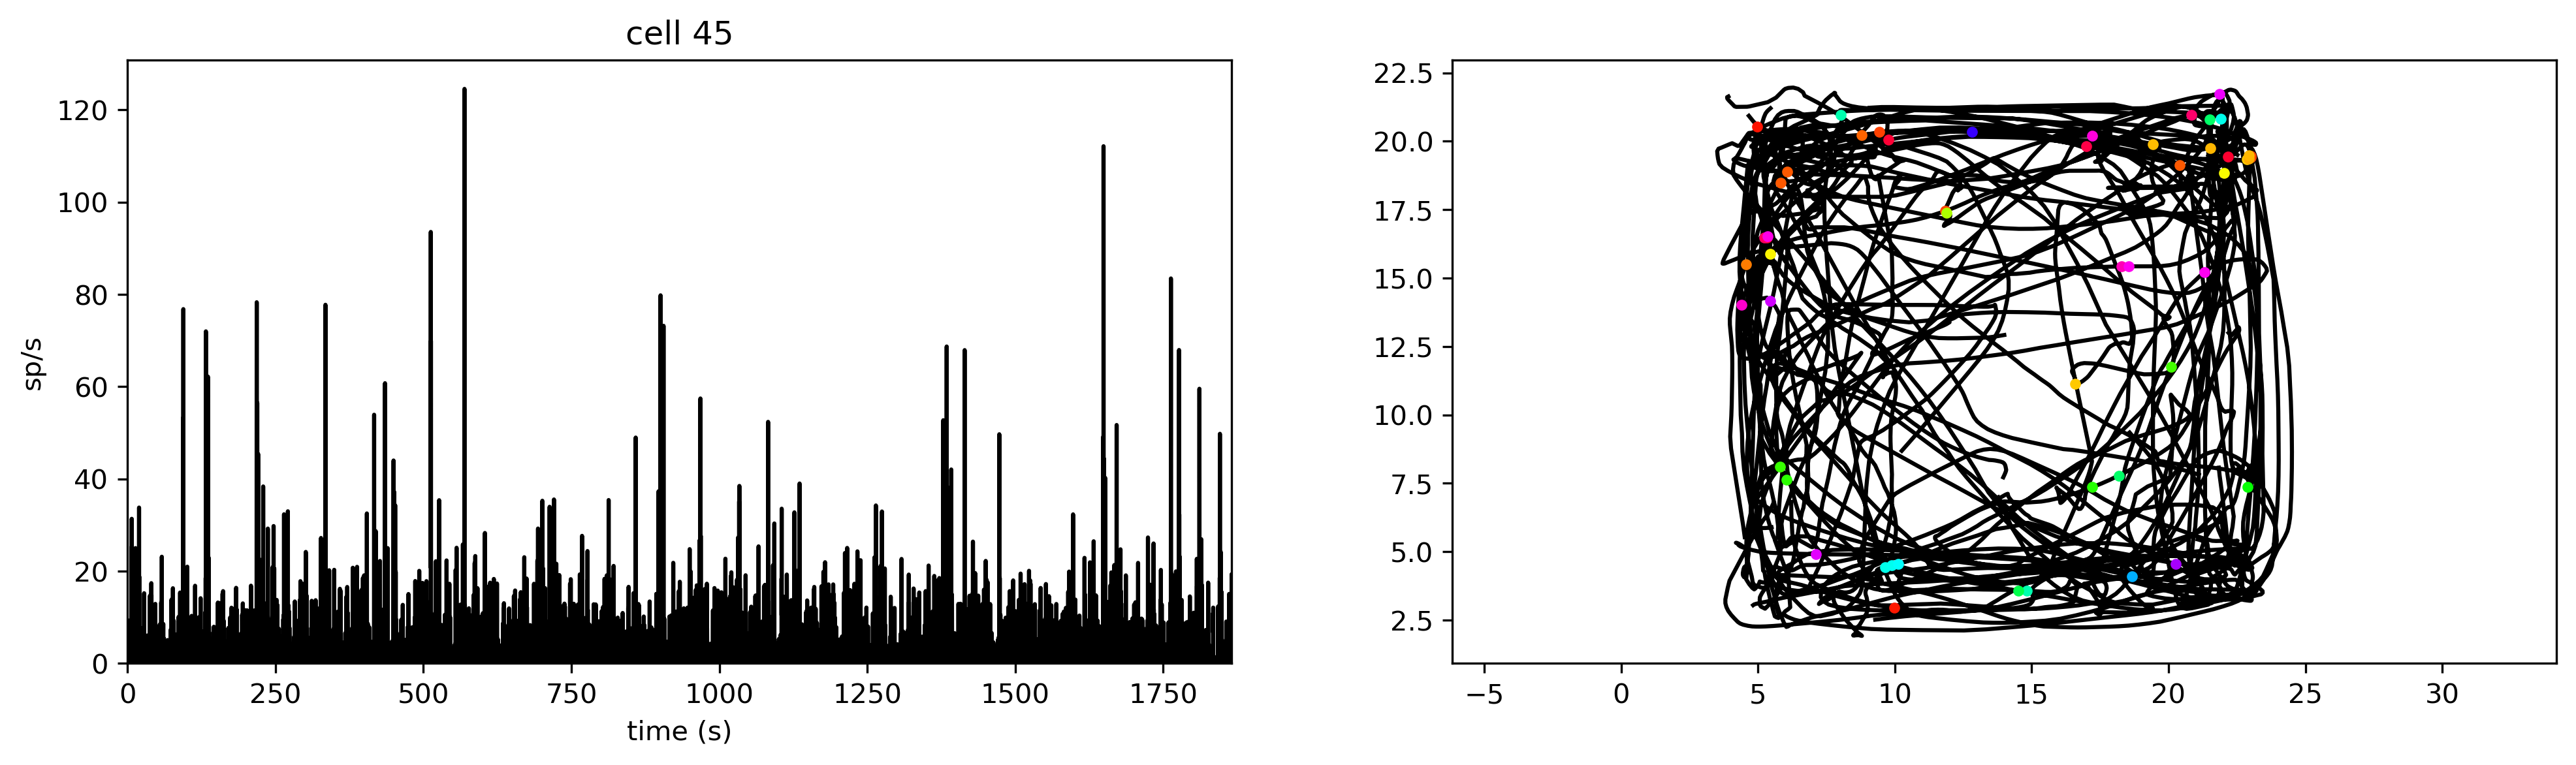

In [10]:
fig, [ax0,ax] = plt.subplots(1,2, figsize=(16,4), dpi=300)

cellind = 45
spikethresh = 20

sptime = np.arange(0, np.size(sps,1)*1/7.5, 1/7.5)

ax0.plot(sptime, sps[cellind,:], color='k')
# ax0.hlines(spikethresh, 0, sptime[-1], color='tab:red')
ax0.set_xlim([0,sptime[-1]])
ax0.set_title('cell {}'.format(cellind))
ax0.set_xlabel('time (s)')
ax0.set_ylabel('sp/s')
ax0.set_ylim([0,np.max(sps[cellind,:])*1.05])

ax.axis('equal')
ax.plot(body_tracking_results['x'] / pxls2cm, body_tracking_results['y'] / pxls2cm, color='k')
for i in range(len(body_tracking_results['head_yaw_deg'])):
    if (~np.isnan(body_tracking_results['head_yaw_deg'][i])) and (sps[cellind,i]>spikethresh):
        ax.plot(body_tracking_results['x'][i] / pxls2cm, body_tracking_results['y'][i] / pxls2cm,
            'o', ms=3, color=cmap[int(body_tracking_results['head_yaw_deg'][i])])
ax.invert_yaxis()
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.set_title('>{} sp/s'.format(spikethresh))

In [8]:
len(body_tracking_results['head_yaw_deg'])

14020

In [94]:
class Wall:

    def __init__(self, x1=0, y1=0, x2=0, y2=0):
        self.start = np.array([x1, y1])
        self.end = np.array([x2, y2])
        self.vector = self.end - self.start

    def get_walls(arena):
        '''
        Finds all the walls in the current RatInABox Environment. RatInABox parses boundary and hole
        parameters into walls by default, so we only need Environment.walls.
        '''
        walls_list = []
        for i in range(len(arena.walls)):
            wall = Wall()
            wall.start = arena.walls[i][0]
            wall.end = arena.walls[i][1]
            wall.vector = wall.end - wall.start
            walls_list.append(wall)
        return walls_list


def closest_wall_per_ray(x, y, hd_radians, walls_list, ego_rays_deg=3):
    '''
    Calculates, for each ray, the distance to the nearest wall along that ray.
    (1) Calculates rays around input head direction.
    (2) For each ray, finds all intersection coordinates with walls.
    (3) For each ray, returns the closest intersection distance.
    (5) Appends closest intersection distances into a list, ray_distances.
    (4) Returns ray_distances.
    Distances are listed clockwise (!) starting from the input head direction.
    '''
    # calculate ray directions in radians around current hd_radians
    rays_rad = hd_radians + np.radians(np.arange(0,360,ego_rays_deg))
    # translate ray radians into vectors (need vectors to calculate intersections)
    rays_vect = np.column_stack((
        np.cos(rays_rad), # x component
        np.sin(rays_rad)  # y component
    ))
    ray_distances = []
    for ray_vector in rays_vect:
        intersections = []
        closest_walls = [] # distances of all intersecting walls
        for wall in walls_list:
            # calculate the determinant (if 0, lines are parallel, no intersection)
            det = np.cross(wall.vector, ray_vector)
            if det == 0:
                continue  # skip this wall and move to the next one
            # calculate the relative position of ray origin to wall start point
            relative_pos = np.array([x, y]) - wall.start
            # calculate how far along the wall line the intersection occurs
            # (t = 0 -> wall.start; t = 1 -> wall.end)
            t = np.cross(relative_pos, ray_vector) / det
            # if t is not between 0 and 1, the intersection is outside the finite wall line
            if t < 0 or t > 1:
                continue  # skip
            # after these checks are passed, calculate the intersection coordinates
            intersection = wall.start + t * wall.vector
            # check if the intersection is really in the direction of the ray
            if np.dot(intersection - np.array([x, y]), ray_vector) < 0:
                continue  # skip
            intersections.append(intersection)
            # calculate Euclidean distance from (x, y) to the intersection
            distance = np.linalg.norm(intersection - np.array([x, y]))
            closest_walls.append(distance)
        min_dist = min(closest_walls) # distance of closest wall for that ray
        ray_distances.append(min_dist) # append that distance to bin distance list
        # repeat for next ray
    return ray_distances # distances of wall for every clockwise 3° ray from input head direction


In [ ]:
print(np.nanmedian(topdlc['tl_corner_x']) / pxls2cm,
np.nanmedian(topdlc['tr_corner_x']) / pxls2cm,
np.nanmedian(topdlc['tl_corner_y']) / pxls2cm,
np.nanmedian(topdlc['br_corner_y']) / pxls2cm)

In [77]:
x1 = np.nanmedian(topdlc['tl_corner_x']) / pxls2cm
x2 = np.nanmedian(topdlc['tr_corner_x']) / pxls2cm
y1 = np.nanmedian(topdlc['tl_corner_y']) / pxls2cm
y2 = np.nanmedian(topdlc['br_corner_y']) / pxls2cm

In [79]:
wall_list = [
    Wall(x1,y1,x2,y1),
    Wall(x1,y1,x1,y2),
    Wall(x2,y1,x2,y2),
    Wall(x1,y2,x2,y2)
]

In [ ]:
sps[cellind,i]>spikethresh

In [102]:
### calc response in egocentric coordinates

# head direction determined for each frame above spike threshold
# distance to wall intersections for all 360 deg is determined

raydists_above_sps_thresh = []

for i in range(len(body_tracking_results['head_yaw_deg'])):
    if (~np.isnan(body_tracking_results['head_yaw_deg'][i])) and (sps[cellind,i]>spikethresh):
        valerr_count = 0
        try:
            ray_distances = closest_wall_per_ray(
                body_tracking_results['x'][i] / pxls2cm,
                body_tracking_results['y'][i] / pxls2cm,
                np.deg2rad(body_tracking_results['head_yaw_deg'][i]),
                wall_list,
                ego_rays_deg=1
            )
            raydists_above_sps_thresh.append(ray_distances)
        except ValueError as e:
            valerr_count += 1

In [103]:
from scipy.interpolate import griddata

In [ ]:
plt.plot(ray_distances)

In [ ]:
plt.subplots(1,1, subplot_kw=dict(projection='polar'), dpi=300)
for rd in raydists_above_sps_thresh:
    plt.plot(np.deg2rad(np.arange(0,360))+(np.pi/2), rd, color='k', alpha=0.2)
plt.yticks([])
plt.xticks([])
plt.tight_layout()

In [280]:
xyl = fm2p.split_xyl(topdlc)

In [ ]:
plt.figure(dpi=300)
for col_i, col in enumerate(xyl[2].columns.values):
    plt.barh(col_i, np.sum(xyl[2][col]>0.8)/6000, color='k')
plt.yticks(range(len(xyl[2].columns.values)), labels=[x[:-11] for x in list(xyl[2].columns.values)])
plt.xlabel('fraction tracked')
plt.title('likelihood thresh=0.8')
plt.tight_layout()

In [ ]:
theta = np.random.uniform(0, 2*np.pi, 360) # Angle
radius = raydists_above_sps_thresh[5]
values = np.random.rand(360)

theta_grid, radius_grid = np.meshgrid(np.linspace(0, 2*np.pi, 40), np.linspace(0, 25, 20))

values_grid = griddata(np.stack((theta, radius), axis=-1), values, (theta_grid, radius_grid), method='linear')

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
contour = ax.pcolormesh(theta_grid, radius_grid, values_grid, cmap='viridis')


In [340]:

def calculate_egocentric_rate_map(trajectory_data, spike_rate, boundaries, distance_bins, angle_bins):
    """
    Calculates the egocentric boundary cell rate map.

    Args:
        trajectory_data (np.array): Array of shape (n_time_bins, 3) containing 
                                    position (x, y) and head direction (theta) at each time bin.
        spike_times (np.array): Array of spike times.
        boundaries (np.array): Array of shape (n_boundary_points, 2) defining the environment boundaries.
        distance_bins (np.array): Array defining the distance bin edges.
        angle_bins (np.array): Array defining the angle bin edges (in radians).

    Returns:
        rate_map (np.array): 2D array representing the firing rate map in egocentric coordinates.
                             Rows correspond to distance bins, columns correspond to angle bins.
    """

    n_distance_bins = len(distance_bins) - 1
    n_angle_bins = len(angle_bins) - 1
    rate_map = np.zeros((n_distance_bins, n_angle_bins))
    occupancy_map = np.zeros((n_distance_bins, n_angle_bins))

    # dt = trajectory_data[1,0] - trajectory_data[0,0]

    # spike_indices = np.floor(spike_times / dt).astype(int)

    for t_idx, (time, x, y, theta) in enumerate(trajectory_data):
      
        # Calculate egocentric distance and angle to the nearest boundary
        min_distance = float('inf')
        min_angle = 0

        for bx, by in boundaries:
            dx = bx - x
            dy = by - y
            distance = np.sqrt(dx**2 + dy**2)
            angle = np.arctan2(dy, dx) - theta
            angle = np.arctan2(np.sin(angle), np.cos(angle))  # Normalize angle to [-pi, pi]

            if distance < min_distance:
                min_distance = distance
                min_angle = angle

        # Find the corresponding bins
        distance_bin_idx = np.digitize(min_distance, distance_bins) - 1
        angle_bin_idx = np.digitize(min_angle, angle_bins) - 1

        # Handle edge cases
        if 0 <= distance_bin_idx < n_distance_bins and 0 <= angle_bin_idx < n_angle_bins:
            occupancy_map[distance_bin_idx, angle_bin_idx] += 1
            # if t_idx in spike_indices:
            rate_map[distance_bin_idx, angle_bin_idx] += spike_rate[int(time)]

    # Calculate firing rate
    rate_map = np.divide(rate_map, occupancy_map, out=np.zeros_like(rate_map), where=occupancy_map!=0)
    
    return rate_map

def plot_rate_map(rate_map, distance_bins, angle_bins):
    """Plots the egocentric rate map."""
    
    plt.figure(figsize=(8, 6))
    extent = [angle_bins[0], angle_bins[-1], distance_bins[0], distance_bins[-1]]
    plt.imshow(rate_map, extent=extent, origin='lower', aspect='auto', cmap='viridis')
    plt.xlabel("Egocentric Angle (rad)")
    plt.ylabel("Egocentric Distance")
    plt.title("Egocentric Boundary Cell Rate Map")
    plt.colorbar(label="Firing Rate (Hz)")
    plt.show()


In [ ]:
plt.figure(figsize=(3,2),dpi=300)
plt.hist(np.deg2rad(body_tracking_results['head_yaw_deg']-180), bins=20, color='k')
plt.xlim([-np.pi,np.pi])
plt.xlabel('head azimuth (rad)')
plt.ylabel('# frames')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(3,2),dpi=300)
plt.hist(body_tracking_results['speed'], bins=20, color='k')
plt.xlim([0,40])
plt.xlabel('speed (cm/s)')
plt.ylabel('# frames')
plt.tight_layout()

In [193]:
traj_arr = np.stack([
    body_tracking_results['x'] / pxls2cm,
    body_tracking_results['y'] / pxls2cm,
    np.deg2rad(body_tracking_results['head_yaw_deg'])
], axis=1)

throw_inds = np.sum(np.isnan(traj_arr),axis=1) > 0
times = np.arange(np.sum(~throw_inds))
trajectory_data = np.delete(traj_arr, throw_inds, axis=0)
trajectory_data = np.concatenate([times[:,np.newaxis], trajectory_data],axis=1)

In [370]:
boundaries = np.array([
    [x1,y1], [x1,y2], [x2,y1], [x2,y2]
])
distance_bins = np.linspace(0,17,8)
angle_bins = np.deg2rad(np.arange(-180,184,8))

In [371]:
rate_map = calculate_egocentric_rate_map(
    trajectory_data=trajectory_data,
    spike_rate=sps[cellind,~throw_inds],
    boundaries=boundaries,
    distance_bins=distance_bins,
    angle_bins=angle_bins
)

In [ ]:
plt.imshow(rate_map)

In [356]:
parula  = [[0.2422, 0.1504, 0.6603],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846],
[0.9835, 0.828, 0.1817],
[0.9807, 0.8342, 0.1787],
[0.9778, 0.8404, 0.1757],
[0.9748, 0.8467, 0.1726],
[0.972, 0.8529, 0.1695],
[0.9694, 0.8591, 0.1665],
[0.9671, 0.8654, 0.1636],
[0.9651, 0.8716, 0.1608],
[0.9634, 0.8778, 0.1582],
[0.9619, 0.884, 0.1557],
[0.9608, 0.8902, 0.1532],
[0.9601, 0.8963, 0.1507],
[0.9596, 0.9023, 0.148],
[0.9595, 0.9084, 0.145],
[0.9597, 0.9143, 0.1418],
[0.9601, 0.9203, 0.1382],
[0.9608, 0.9262, 0.1344],
[0.9618, 0.932, 0.1304],
[0.9629, 0.9379, 0.1261],
[0.9642, 0.9437, 0.1216],
[0.9657, 0.9494, 0.1168],
[0.9674, 0.9552, 0.1116],
[0.9692, 0.9609, 0.1061],
[0.9711, 0.9667, 0.1001],
[0.973, 0.9724, 0.0938],
[0.9749, 0.9782, 0.0872],
[0.9769, 0.9839, 0.0805]]

In [364]:
from matplotlib.colors import LinearSegmentedColormap
parula_map = LinearSegmentedColormap.from_list('parula', parula)

In [ ]:
np.max(rate_map)

In [ ]:
fig, axs = plt.subplots(10, 9, figsize=(12,12), dpi=300, subplot_kw={'projection': 'polar'})
axs = axs.flatten()

for cellind in range(85):

    ax = axs[cellind]

    rate_map = calculate_egocentric_rate_map(
        trajectory_data=trajectory_data,
        spike_rate=sps[cellind,~throw_inds],
        boundaries=boundaries,
        distance_bins=distance_bins,
        angle_bins=angle_bins
    )

    rate_mesh_X, rate_mesh_Y = np.meshgrid(angle_bins+(np.pi/2), distance_bins)
    ax.pcolormesh(rate_mesh_X, rate_mesh_Y, rate_map, edgecolors='face', cmap=parula_map)#, vmin=0, vmax=np.percentile(rate_map.flatten(), 99))
    ax.set_yticks([])
    ax.set_xticks([])
    # colorbar(label='sp/s')

    ax.set_title(cellind)

for cellind in range(85, 90):
    axs[cellind].axis('off')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
rate_mesh_X, rate_mesh_Y = np.meshgrid(angle_bins+(np.pi/2), distance_bins) # +(np.pi/2)
plt.pcolormesh(rate_mesh_X, rate_mesh_Y, rate_map, edgecolors='face', cmap=parula_map)
plt.yticks([])
plt.xticks([])
plt.colorbar(label='sp/s')

In [ ]:
np.deg2rad(body_tracking_results['head_yaw_deg'][i])

In [ ]:
body_tracking_results['x'][i] / pxls2cm, body_tracking_results['y'][i] / pxls2cm

In [ ]:
int(body_tracking_results['head_yaw_deg'][i])

In [105]:
histbins = [
    np.arange(
        np.nanmedian(topdlc['tl_corner_x']),
        np.nanmedian(topdlc['tr_corner_x'])+pxls2cm,
        pxls2cm), # 1 cm bins
    np.arange(
        np.nanmedian(topdlc['tl_corner_y']),
        np.nanmedian(topdlc['bl_corner_y'])+pxls2cm,
        pxls2cm
    )
]

H, xedges, yedges = np.histogram2d(
    x=body_tracking_results['x'],
    y=body_tracking_results['y'],
    bins=histbins
)

wH, _, _ = np.histogram2d(
    x=body_tracking_results['x'],
    y=body_tracking_results['y'],
    bins=histbins,
    weights=sps[1,:]
)

In [ ]:
plt.imshow(wH)

In [ ]:
plt.imshow(H)

In [78]:
import scipy.stats

In [63]:
import sklearn

In [ ]:
x = body_tracking_results['x'] / pxls2cm
y = body_tracking_results['y'] / pxls2cm
xmin = np.nanmedian(topdlc['tl_corner_x']) / pxls2cm
xmax = np.nanmedian(topdlc['tr_corner_x']) / pxls2cm
ymin = np.nanmedian(topdlc['tl_corner_y']) / pxls2cm
ymax = np.nanmedian(topdlc['bl_corner_y']) / pxls2cm
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
values = np.vstack([x, y])
values = values[:,np.sum(np.isnan(values), axis=0)==0]
kernel = scipy.stats.gaussian_kde(values)
positions = np.vstack([xx.ravel(), yy.ravel()])
f = np.reshape(kernel(positions).T, xx.shape)
fig, ax = plt.subplots(1,1)
cfset = ax.contourf(xx, yy, f, cmap='Blues')
cset = ax.contour(xx, yy, f, colors='k')
# ax.clabel(cset, inline=1, fontsize=10)
ax.invert_yaxis()
ax.axis('equal')

In [ ]:
fig, ax = plt.subplots(1,1)
im = NonUniformImage(ax, interpolation='bilinear', cmap='gray')
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
im.set_data(xcenters, ycenters, H)
ax.add_image(im)

In [ ]:
plt.plot(body_tracking_results['head_yaw_deg'])

In [5]:
twop = fm2p.read_h5(r'K:\Mini2P\241219_DMM_DMM037_freemoving\241219_DMM_DMM037_freemoving_01\241219_DMM_DMM037_freemoving_01_twophoton.h5')
top = fm2p.read_h5(r'K:\Mini2P\241219_DMM_DMM037_freemoving\241219_DMM_DMM037_freemoving_01\241219_DMM_DMM037_freemoving_01_top_tracking.h5')

In [8]:
x_vals, y_vals, likelihood = fm2p.split_xyl(topdlc)

# Threshold by likelihoods
x_vals = fm2p.apply_liklihood_thresh(x_vals, likelihood, threshold=0.8)
y_vals = fm2p.apply_liklihood_thresh(y_vals, likelihood, threshold=0.8)

In [ ]:
['{} {:.03}% good'.format(c, (np.sum(~np.isnan(x_vals[c]))/len(x_vals[c]))*100) for c in x_vals.columns.values]